In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend
from tensorflow.keras.constraints import min_max_norm
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
# Function to initialize GPU
def prep_gpu():
    phy_gpus = tf.config.list_physical_devices(device_type='GPU')

    for gpu in phy_gpus:
        tf.config.experimental.set_memory_growth(device=gpu, enable=True)

    log_gpus = tf.config.list_logical_devices(device_type='GPU')
    phy_cpus = tf.config.list_physical_devices(device_type='CPU')
    log_cpus = tf.config.list_logical_devices(device_type='CPU')

    print("Physical GPUs: {}\tLogical GPUs: {}\nPhysical CPUs: {}\tLogical CPUs: {}".format(len(phy_gpus),
                                                                                             len(log_gpus),
                                                                                             len(phy_cpus),
                                                                                             len(log_cpus)))

In [4]:
df = pd.read_csv(filepath_or_buffer='./download/DATA/cancer_classification.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [5]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,benign_0__mal_1
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


<AxesSubplot:xlabel='benign_0__mal_1', ylabel='count'>

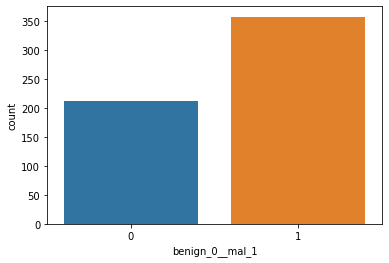

In [ ]:
sns.countplot(x=df['benign_0__mal_1'])

In [ ]:
df.corr()['benign_0__mal_1'].sort_values()

worst concave points      -0.793566
worst perimeter           -0.782914
mean concave points       -0.776614
worst radius              -0.776454
mean perimeter            -0.742636
worst area                -0.733825
mean radius               -0.730029
mean area                 -0.708984
mean concavity            -0.696360
worst concavity           -0.659610
mean compactness          -0.596534
worst compactness         -0.590998
radius error              -0.567134
perimeter error           -0.556141
area error                -0.548236
worst texture             -0.456903
worst smoothness          -0.421465
worst symmetry            -0.416294
mean texture              -0.415185
concave points error      -0.408042
mean smoothness           -0.358560
mean symmetry             -0.330499
worst fractal dimension   -0.323872
compactness error         -0.292999
concavity error           -0.253730
fractal dimension error   -0.077972
symmetry error             0.006522
texture error              0

<AxesSubplot:>

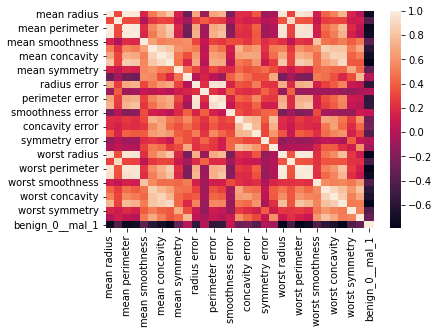

In [ ]:
sns.heatmap(df.corr())

In [ ]:
# Separating features from labels
label_col = ['benign_0__mal_1']
features = list(set(list(df.columns.values)).difference(label_col))
X = df[features]
y = df[label_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

print("Number of features: {}".format(len(features)))
print("Number of training records: {}".format(len(X_train)))

Number of features: 30
Number of training records: 426


In [3]:
# Synthetic data
X, y = datasets.make_classification(n_samples=10000, n_features=30, n_informative=25, n_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [4]:
# Normalizing input features
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
prep_gpu()

Physical GPUs: 1	Logical GPUs: 1
Physical CPUs: 1	Logical CPUs: 1


In [6]:
# Predict with data and check performance
def predict(model, X_test, y_test):
    y_pred = model.predict(X_test) > 0.5
    print(classification_report(y_true=np.array(y_test), y_pred=y_pred))
    print("\n")
    print(confusion_matrix(y_true=np.array(y_test), y_pred=y_pred))

In [8]:
# Define model
backend.clear_session()

model = Sequential()

model.add(Input(shape=(30,)))
model.add(layer=Dense(32, activation='relu'))
model.add(layer=Dense(16, activation='relu'))
model.add(layer=Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Fit the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.fit(x=X_train, y=y_train, epochs=100, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.7012 - loss: 0.6185 - val_accuracy: 0.8220 - val_loss: 0.5135
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8281 - loss: 0.4373 - val_accuracy: 0.8348 - val_loss: 0.3897
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8512 - loss: 0.3550 - val_accuracy: 0.8380 - val_loss: 0.3604
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8645 - loss: 0.3228 - val_accuracy: 0.8736 - val_loss: 0.2977
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8717 - loss: 0.3066 - val_accuracy: 0.8836 - val_loss: 0.2830
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8811 - loss: 0.2839 - val_accuracy: 0.8824 - val_loss: 0.2883
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8856 - loss: 0.2741 - val_accuracy: 0.8992 - val_loss: 0.2513

<AxesSubplot:>

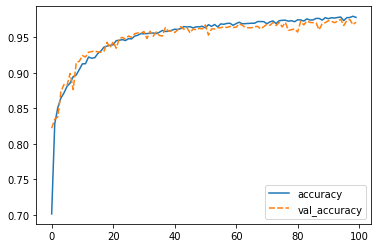

In [10]:
metrics = pd.DataFrame(model.history.history)
sns.lineplot(data=metrics[['accuracy', 'val_accuracy']])

In [11]:
predict(model=model, X_test=X_test, y_test=y_test)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1250
           1       0.98      0.96      0.97      1250

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



[[1224   26]
 [  45 1205]]


In [6]:
# Build model with early stopping callback
# Define model
backend.clear_session()

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)

model = Sequential()

model.add(Input(shape=(30,)))
model.add(layer=Dense(32, activation='relu'))
model.add(layer=Dense(16, activation='relu'))
model.add(layer=Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Fit model with early stopping
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.fit(x=X_train, y=y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.7208 - loss: 0.6074 - val_accuracy: 0.7908 - val_loss: 0.5257
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8052 - loss: 0.4578 - val_accuracy: 0.8180 - val_loss: 0.4280
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8184 - loss: 0.4053 - val_accuracy: 0.8268 - val_loss: 0.4040
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8288 - loss: 0.3855 - val_accuracy: 0.8284 - val_loss: 0.3956
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8260 - loss: 0.3799 - val_accuracy: 0.8272 - val_loss: 0.3906
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8321 - loss: 0.3744 - val_accuracy: 0.8268 - val_loss: 0.3852
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8359 - loss: 0.3674 - val_accuracy: 0.8284 - val_loss: 0.3996

<AxesSubplot:>

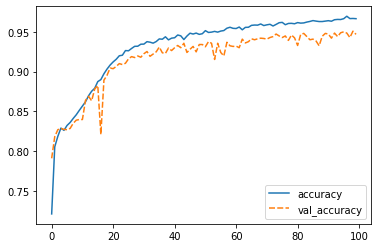

In [8]:
metrics = pd.DataFrame(model.history.history)
sns.lineplot(data=metrics[['accuracy', 'val_accuracy']])

In [11]:
predict(model=model, X_test=X_test, y_test=y_test)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1220
           1       0.93      0.97      0.95      1280

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



[[1129   91]
 [  42 1238]]


In [12]:
# Build model with dropout layers
# Define model
backend.clear_session()

model = Sequential()

model.add(Input(shape=(30,)))
model.add(layer=Dense(32, activation='relu'))
model.add(layer=Dropout(0.5))
model.add(layer=Dense(16, activation='relu'))
model.add(layer=Dropout(0.5))
model.add(layer=Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Fit model with dropout layers
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.fit(x=X_train, y=y_train, epochs=100, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.5648 - loss: 0.6791 - val_accuracy: 0.7128 - val_loss: 0.6276
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.6803 - loss: 0.6062 - val_accuracy: 0.8152 - val_loss: 0.5198
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.7463 - loss: 0.5375 - val_accuracy: 0.8232 - val_loss: 0.4494
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.7649 - loss: 0.5034 - val_accuracy: 0.8324 - val_loss: 0.4159
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.7856 - loss: 0.4715 - val_accuracy: 0.8388 - val_loss: 0.3964
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.7968 - loss: 0.4509 - val_accuracy: 0.8492 - val_loss: 0.3718
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8077 - loss: 0.4394 - val_accuracy: 0.8576 - val_loss: 0.3601

<AxesSubplot:>

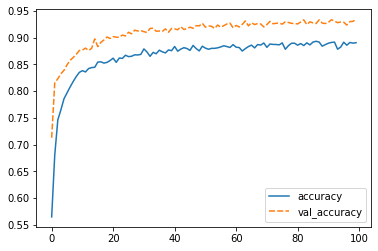

In [15]:
metrics = pd.DataFrame(model.history.history)
sns.lineplot(data=metrics[['accuracy', 'val_accuracy']])

In [16]:
predict(model=model, X_test=X_test, y_test=y_test)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1220
           1       0.94      0.94      0.94      1280

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



[[1137   83]
 [  81 1199]]


In [7]:
# Build model with dropout layers and early stopping
# Define model
backend.clear_session()

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)

model = Sequential()

model.add(Input(shape=(30,)))
model.add(layer=Dense(32, activation='relu'))
model.add(layer=Dropout(0.5))
model.add(layer=Dense(16, activation='relu'))
model.add(layer=Dropout(0.5))
model.add(layer=Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Fit model with dropout layers
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.fit(x=X_train, y=y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

Epoch 1/150
235/235 [==============================] - 1s 3ms/step - accuracy: 0.5585 - loss: 0.6868 - val_accuracy: 0.7628 - val_loss: 0.6522
Epoch 2/150
235/235 [==============================] - 1s 3ms/step - accuracy: 0.6551 - loss: 0.6286 - val_accuracy: 0.8236 - val_loss: 0.5447
Epoch 3/150
235/235 [==============================] - 1s 3ms/step - accuracy: 0.7401 - loss: 0.5453 - val_accuracy: 0.8360 - val_loss: 0.4282
Epoch 4/150
235/235 [==============================] - 1s 3ms/step - accuracy: 0.7844 - loss: 0.4699 - val_accuracy: 0.8544 - val_loss: 0.3770
Epoch 5/150
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8024 - loss: 0.4424 - val_accuracy: 0.8564 - val_loss: 0.3521
Epoch 6/150
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8179 - loss: 0.4139 - val_accuracy: 0.8596 - val_loss: 0.3317
Epoch 7/150
235/235 [==============================] - 1s 3ms/step - accuracy: 0.8267 - loss: 0.4028 - val_accuracy: 0.8652 - val_loss: 0.3140

<AxesSubplot:>

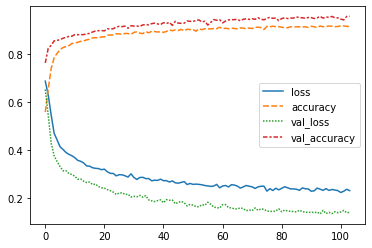

In [10]:
metrics = pd.DataFrame(model.history.history)
sns.lineplot(data=metrics)

In [11]:
# Predict with data and check performance
y_pred = model.predict(X_test) > 0.5
print(classification_report(y_true=np.array(y_test), y_pred=y_pred))
print("\n")
print(confusion_matrix(y_true=np.array(y_test), y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1278
           1       0.96      0.96      0.96      1222

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



[[1223   55]
 [  53 1169]]
